In [13]:
#Import Libraries
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as XGBClassifierb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix,precision_recall_fscore_support
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv(r'D:\Work Station\startups\data\cleaned_data.csv')
df.head()

,status,first_investment_at,last_investment_at,investment_rounds,funding_rounds,funding_total_usd,milestones,relationships,lat,lng,...,country_code_ISR,country_code_ITA,country_code_NLD,country_code_Other,country_code_SWE,country_code_USA,isClosed,active_days,founded_at,closed_at
0,operating,2009-01-01,2012-01-01,2.372057,3.00000,3.975000e+07,5.000000,17.000000,47.606209,-122.332071,...,False,False,False,False,False,True,1,5844.0,2005-01-01,2021-01-01
1,operating,2009-01-01,2012-01-01,2.372057,1.65976,1.481652e+07,1.199402,2.852067,37.564512,-52.123066,...,False,False,False,False,False,True,1,4749.0,2008-01-01,2021-01-01
2,operating,2009-01-01,2012-01-01,2.372057,1.65976,1.481652e+07,1.199402,2.852067,37.564512,-52.123066,...,False,False,False,False,False,True,1,4749.0,2008-01-01,2021-01-01
3,operating,2009-01-01,2012-01-01,2.372057,1.65976,1.481652e+07,1.199402,2.000000,30.427755,-9.598107,...,False,False,False,True,False,False,1,5114.0,2007-01-01,2021-01-01
4,operating,2009-01-01,2012-01-01,2.372057,1.65976,1.481652e+07,1.199402,2.852067,22.307159,73.181219,...,False,False,False,False,False,False,1,4749.0,2008-01-01,2021-01-01


Target and Feature Columns

In [10]:
X = df.drop('active_days', axis=1)
y = df['active_days']

In [12]:
df.active_days.value_counts()

active_days
 1     116180
 0      10697
 2      10421
 3       8998
 4       7325
        ...  
-6          3
-40         1
-7          1
-25         1
-9          1
Name: count, Length: 124, dtype: int64

Using SOMTE and Data Split into train, validation, and test sets

In [11]:
def split_data_with_smote(X, y, test_size=0.2, val_size=0.2):
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    
    val_proportion = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_proportion, random_state=42, stratify=y_train_val
    )
    
    # Apply SMOTE to the training data only
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    return X_train_smote, X_val, X_test, y_train_smote, y_val, y_test

X_train_smote, X_val, X_test, y_train_smote, y_val, y_test = split_data_with_smote(X, y)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Feature Scaling using Standard Scalar

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the SMOTE-transformed training data and transform it
X_train_scaled = scaler.fit_transform(X_train_smote)

In [ ]:
# Transform the validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Model Selection

In [ ]:
from xgboost import XGBClassifier  # Import XGBClassifier


# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Gaussian Discriminant Analysis (GDA)": QDA(),
    "Feed Forward Neural Network": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42) 
}

Evaluating Models

In [ ]:
def evaluate_model(name, model, X_val_scaled, y_val):
    # Fit the model
    model.fit(X_train_scaled, y_train_smote)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Calculate probabilities if the model supports it
    y_val_proba = None
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val_scaled)
    
    # Classification report
    report = classification_report(y_val, y_val_pred, output_dict=True)
    
    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')
    
    # AUC ROC Score
    auc_roc = None
    if y_val_proba is not None:
        try:
            auc_roc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')
        except ValueError:
            auc_roc = None  # Handle models that don't support probability prediction
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    return {
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC ROC': auc_roc,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix
    }

In [ ]:
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(name, model, X_val_scaled, y_val)
    results.append(result)
    print(f"Results for {name}:")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print(f"AUC ROC: {result['AUC ROC']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Classification Report:\n{result['Classification Report']}\n")
    print("================================================================================================================================ \n")

Evaluating Logistic Regression...
Results for Logistic Regression:
Precision: 0.9222367317855464
Recall: 0.7203327312965837
F1 Score: 0.7926451806568797
AUC ROC: None
Confusion Matrix:
[[ 1658   738]
 [10256 26659]]
Classification Report:
{'0': {'precision': 0.13916400872922613, 'recall': 0.6919866444073456, 'f1-score': 0.23172606568832985, 'support': 2396.0}, '1': {'precision': 0.973062744096069, 'recall': 0.7221725585805229, 'f1-score': 0.829052120910561, 'support': 36915.0}, 'accuracy': 0.7203327312965837, 'macro avg': {'precision': 0.5561133764126476, 'recall': 0.7070796014939342, 'f1-score': 0.5303890932994454, 'support': 39311.0}, 'weighted avg': {'precision': 0.9222367317855464, 'recall': 0.7203327312965837, 'f1-score': 0.7926451806568797, 'support': 39311.0}}


Evaluating Gaussian Discriminant Analysis (GDA)...
Results for Gaussian Discriminant Analysis (GDA):
Precision: 0.9476222940332999
Recall: 0.9497596092696701
F1 Score: 0.9342072478130714
AUC ROC: None
Confusion Matrix:
[

In [ ]:
# Extract model names and their corresponding metrics
model_names = [result['Model'] for result in results]
precisions = [result['Precision'] for result in results]
recalls = [result['Recall'] for result in results]
f1_scores = [result['F1 Score'] for result in results]
auc_roc_scores = [result['AUC ROC'] for result in results]

# Create a DataFrame to include all performance metrics
results_df = pd.DataFrame({
    'Model Name': model_names,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC ROC': auc_roc_scores
}).sort_values(by=["AUC ROC"], ascending=False)

# Print the sorted DataFrame
print(results_df)

                             Model Name  Precision    Recall  F1 Score AUC ROC
0                   Logistic Regression   0.922237  0.720333  0.792645    None
1  Gaussian Discriminant Analysis (GDA)   0.947622  0.949760  0.934207    None
2           Feed Forward Neural Network   0.932631  0.869146  0.893599    None
3                         Random Forest   0.928730  0.912365  0.919548    None
4                               XGBoost   0.934408  0.921549  0.927161    None


We chose GDA for the Tesing Phase as it gives more accurate results.

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define the Gaussian Discriminant Analysis (GDA) model
best_model = QDA()

# Fit the model on the training set
best_model.fit(X_train_scaled, y_train_smote)

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Predict probabilities for ROC AUC curve
try:
    y_test_proba = best_model.predict_proba(X_test_scaled)
    # Calculate AUC ROC for the test set
    auc_roc_test = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    print(f"AUC ROC Score for Test Set: {auc_roc_test:.4f}")
except (ValueError, AttributeError):
    # Handle models that don't support probability prediction
    auc_roc_test = None
    print("AUC ROC could not be calculated for the test set.")

# Evaluate the model on the test set
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Set:\n")
print(test_report)

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix for Test Set:\n", conf_matrix_test)


AUC ROC could not be calculated for the test set.
Classification Report for Test Set:

              precision    recall  f1-score   support

           0       0.89      0.19      0.31      2396
           1       0.95      1.00      0.97     36915

    accuracy                           0.95     39311
   macro avg       0.92      0.59      0.64     39311
weighted avg       0.95      0.95      0.93     39311


Confusion Matrix for Test Set:
 [[  444  1952]
 [   57 36858]]


Visualization of the Best Model's Performance

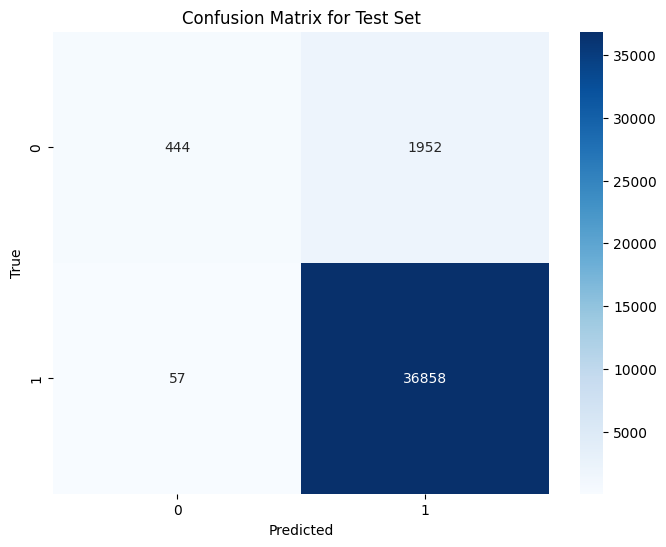

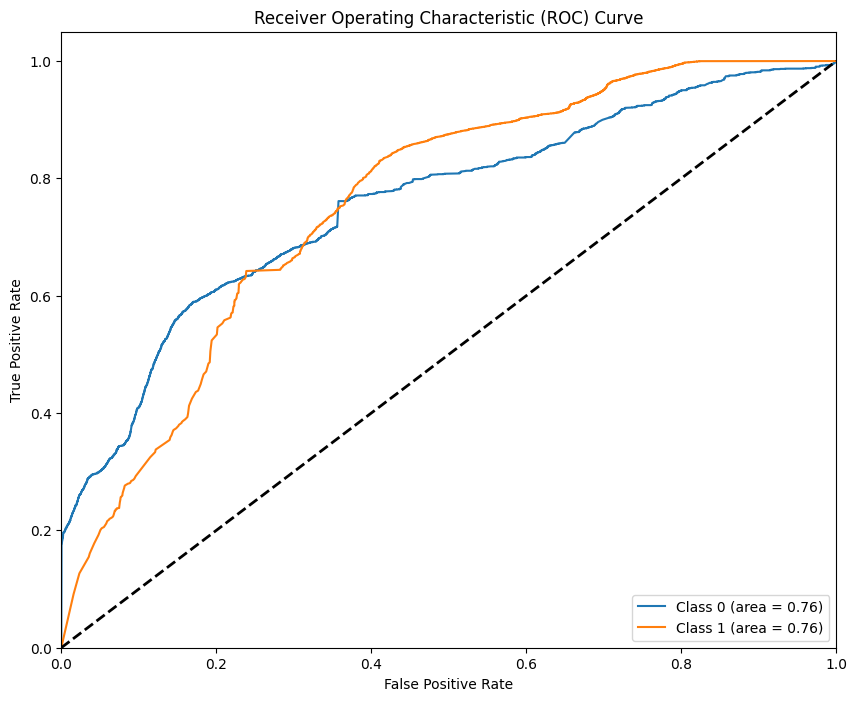

In [ ]:
# Visualization of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

# ROC Curve Visualization
n_classes = y_test_proba.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Saving the best model

In [ ]:
import pickle

# Save the model to a pickle file
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")

Model saved to best_model.pkl
